In [8]:
import os
import json
import pandas as pd
import scipy as sp
from sklearn.preprocessing import LabelEncoder 
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import datetime
import pickle
import matplotlib as mpl
import seaborn as sns
from pprint import pprint

In [9]:
sns.set_style("white")
sns.set_context("talk")
mpl.rcParams['figure.dpi'] = 600
plt.rcParams.update({'font.size': 18})

In [2]:
def read_all_data():
    paths = []
    dirs = os.listdir('normalized_train_data')
    for dir in dirs:
        filenames = os.listdir(f'normalized_train_data/{dir}')
        paths += [f'normalized_train_data/{dir}/{filename}' for filename in filenames]
    paths = sorted(paths)
    dfs = []
    for filepath in tqdm(paths, desc='Loading data'):
        df = pd.read_csv(filepath)
        df.drop(columns=['Unnamed: 0'], inplace=True)
        dfs.append(df)
    dfs = pd.concat(dfs)
    return dfs
data = read_all_data()

Loading data:   0%|          | 0/69 [00:00<?, ?it/s]

In [24]:
def load_encoders(features):
    column_encoders = []
    for feature in features:
        with open(f'./label_encoders/{feature}.pickle', 'rb') as handle:
            encoder = pickle.load(handle)
        column_encoders.append((feature, encoder))
    return column_encoders

features_string_categories = [
    'user_id_hash',
    'target_id_hash',
    'syndicator_id_hash',
    'campaign_id_hash',
    'target_item_taxonomy',
    'placement_id_hash',
    'publisher_id_hash',
    'source_id_hash',
    'source_item_type',
    'browser_platform',
    'country_code',
    'region',
]
column_encoders = load_encoders(features_string_categories)
column_encoders = dict(column_encoders)

# Correlations

In [5]:
corr_mat = data[['empiric_calibrated_recs', 'empiric_clicks', 'user_recs', 'user_clicks', 'user_target_recs', 'os_family', 'browser_platform', 'country_code', 'region', 'source_item_type', 'is_click']].corr()

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
corr_mat.rename(
    columns=dict([(c, c.replace('_', ' ').title()) for c in corr_mat.columns]),
    index=dict([(c, c.replace('_', ' ').title()) for c in corr_mat.index]),
    inplace=True)
sns.heatmap(corr_mat, annot=True, linewidth=.5, ax=ax, vmin=-1, vmax=1, fmt='.3f', cmap="seismic", cbar_kws={'label': 'Pearson correlation'})
ax.tick_params(axis='x', rotation=45)
fig.savefig('./correlations.png')
plt.show()

# Categorical features distributions

In [44]:
max_timestamp = data['page_view_start_time'].max()
three_days_ago = (datetime.datetime.fromtimestamp(max_timestamp/1000) - datetime.timedelta(days=3)).replace(hour=0, minute=0, second=0, microsecond=0)
three_days_ago = int(datetime.datetime.timestamp(three_days_ago) * 1000)
last_three_days = data[data['page_view_start_time'] >= three_days_ago]
def reconstruct():
    df = last_three_days.copy(deep=True)
    for column, encoder in tqdm(column_encoders.items()):
        df[column] = encoder.inverse_transform(df[column].to_list())
    return df
last_three_days_recon = reconstruct()
last_three_days_recon['country_code'].fillna('Null', inplace=True)
last_three_days_recon['region'].fillna('Null', inplace=True)
last_three_days_recon['target_item_taxonomy_upper'] = last_three_days_recon['target_item_taxonomy'].str.split('~').str[0]

  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Mark\AppData\Local\Temp\ipykernel_20360\2676950156.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  last_three_days_recon['country_code'].fillna('Null', inplace=True)
C:\Users\Mark\AppData\Local\Temp\ipykernel_20360\2676950156.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

Item taxonomy

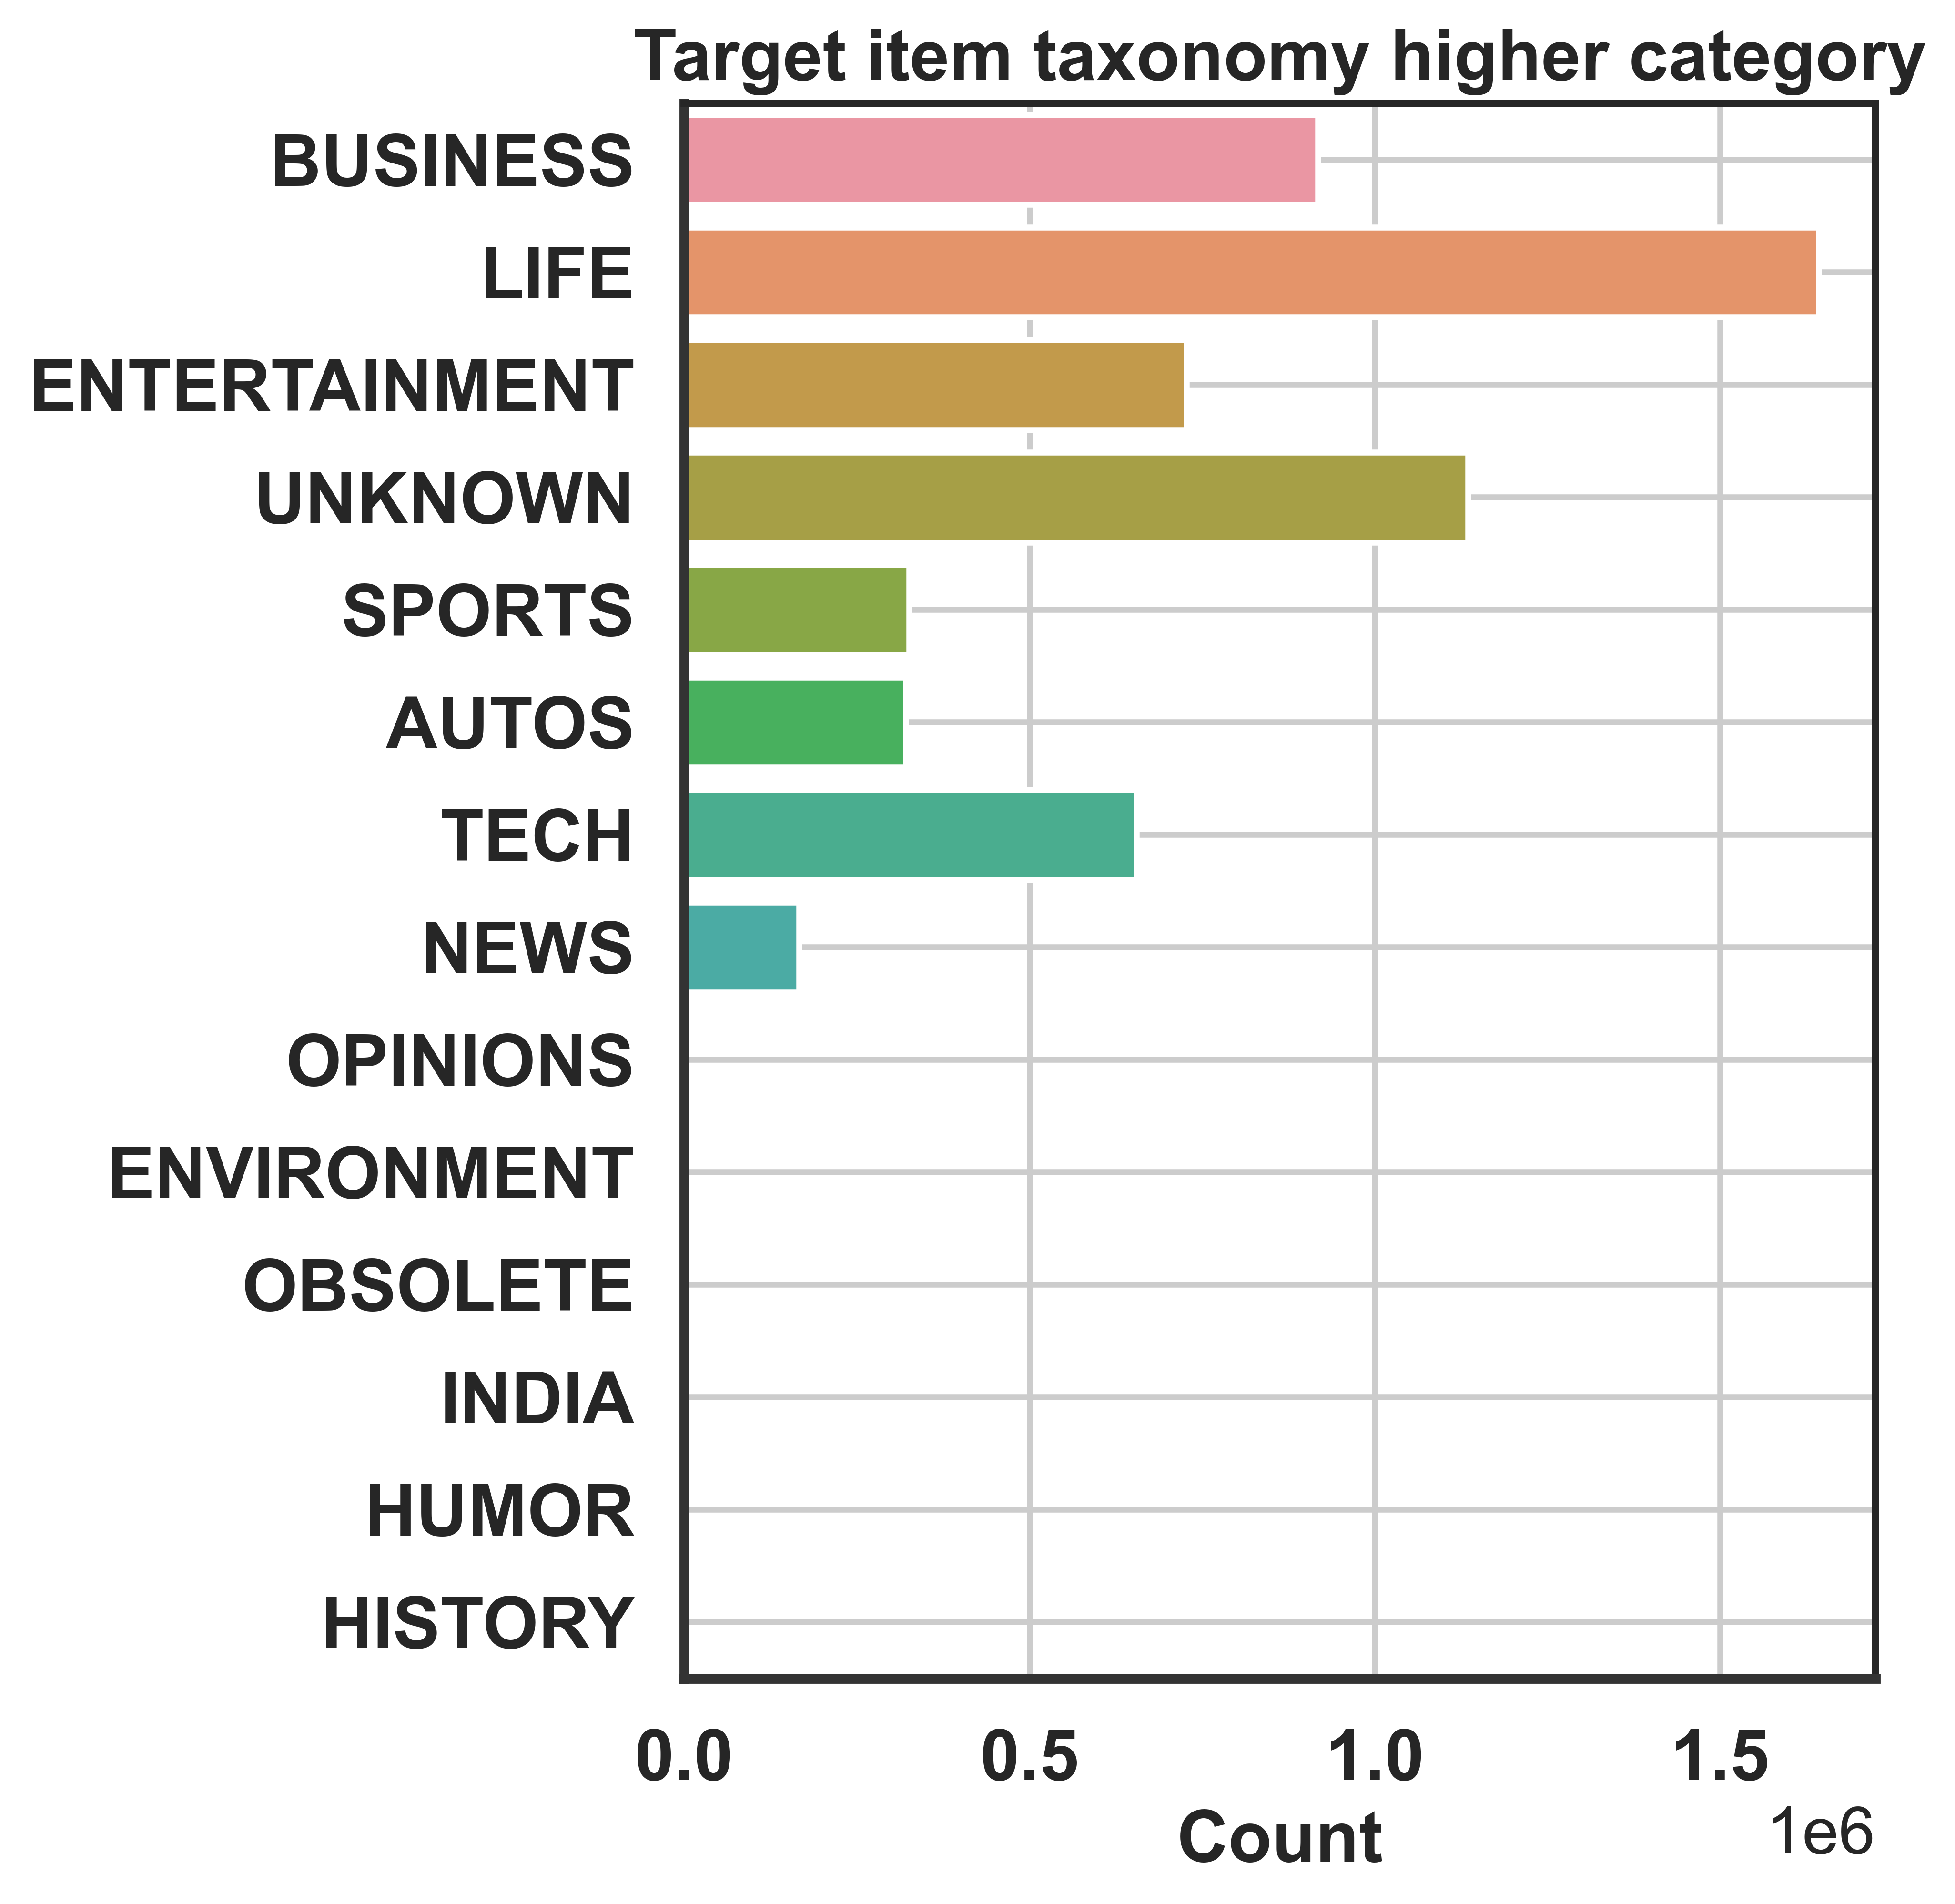

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
sns.countplot(data=last_three_days_recon, y='target_item_taxonomy_upper')
ax.set_title('Target item taxonomy higher category', fontdict={'weight': 'bold'})
# ax.set_ylabel('Target item taxonomy higher category', fontdict={'weight': 'bold'})
ax.set_ylabel('')
ax.set_xlabel('Count', fontdict={'weight': 'bold'})
ax.grid()
ax.tick_params(axis ='both', which ='major', labelsize = 18)
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
fig.tight_layout()
fig.savefig('./histogram-target-item-category.png')
plt.show()

Source item type

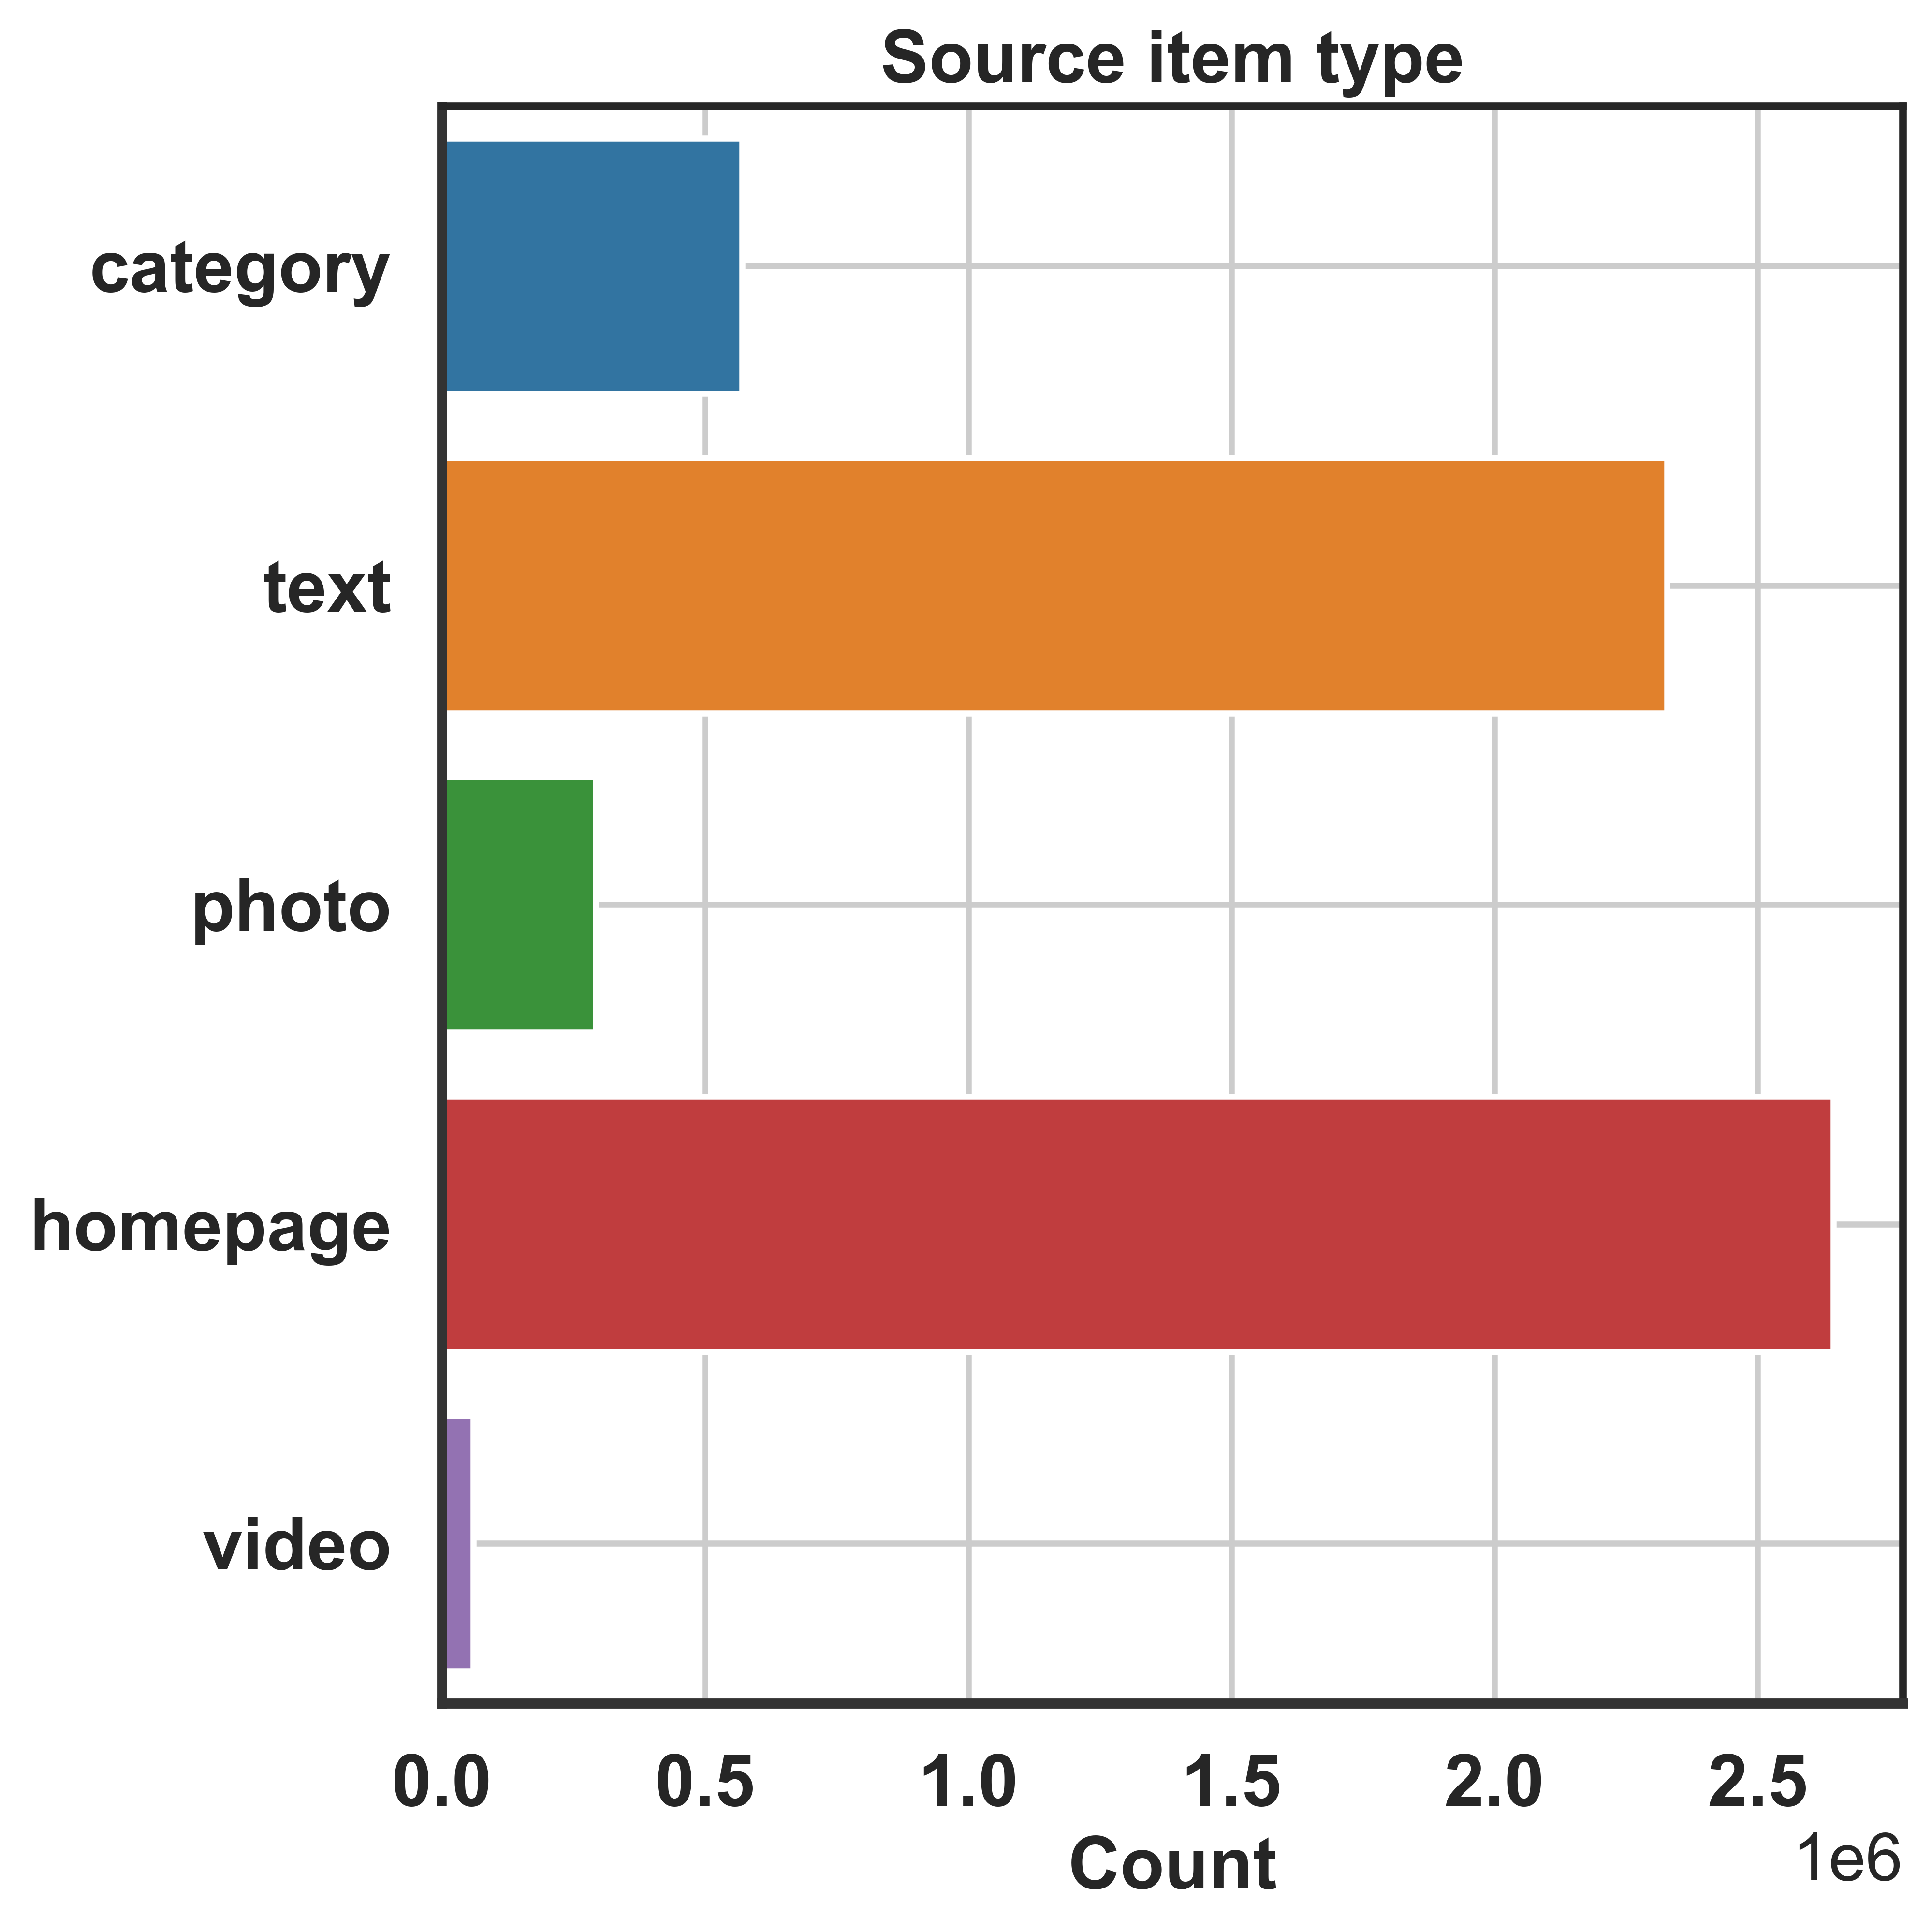

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
sns.countplot(data=last_three_days_recon, y='source_item_type')
ax.set_title('Source item type', fontdict={'weight': 'bold'})
# ax.set_ylabel('Target item taxonomy higher category', fontdict={'weight': 'bold'})
ax.set_ylabel('')
ax.set_xlabel('Count', fontdict={'weight': 'bold'})
ax.grid()
ax.tick_params(axis ='both', which ='major', labelsize = 18)
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
fig.tight_layout()
fig.savefig('./histogram-source-item-type.png')
plt.show()

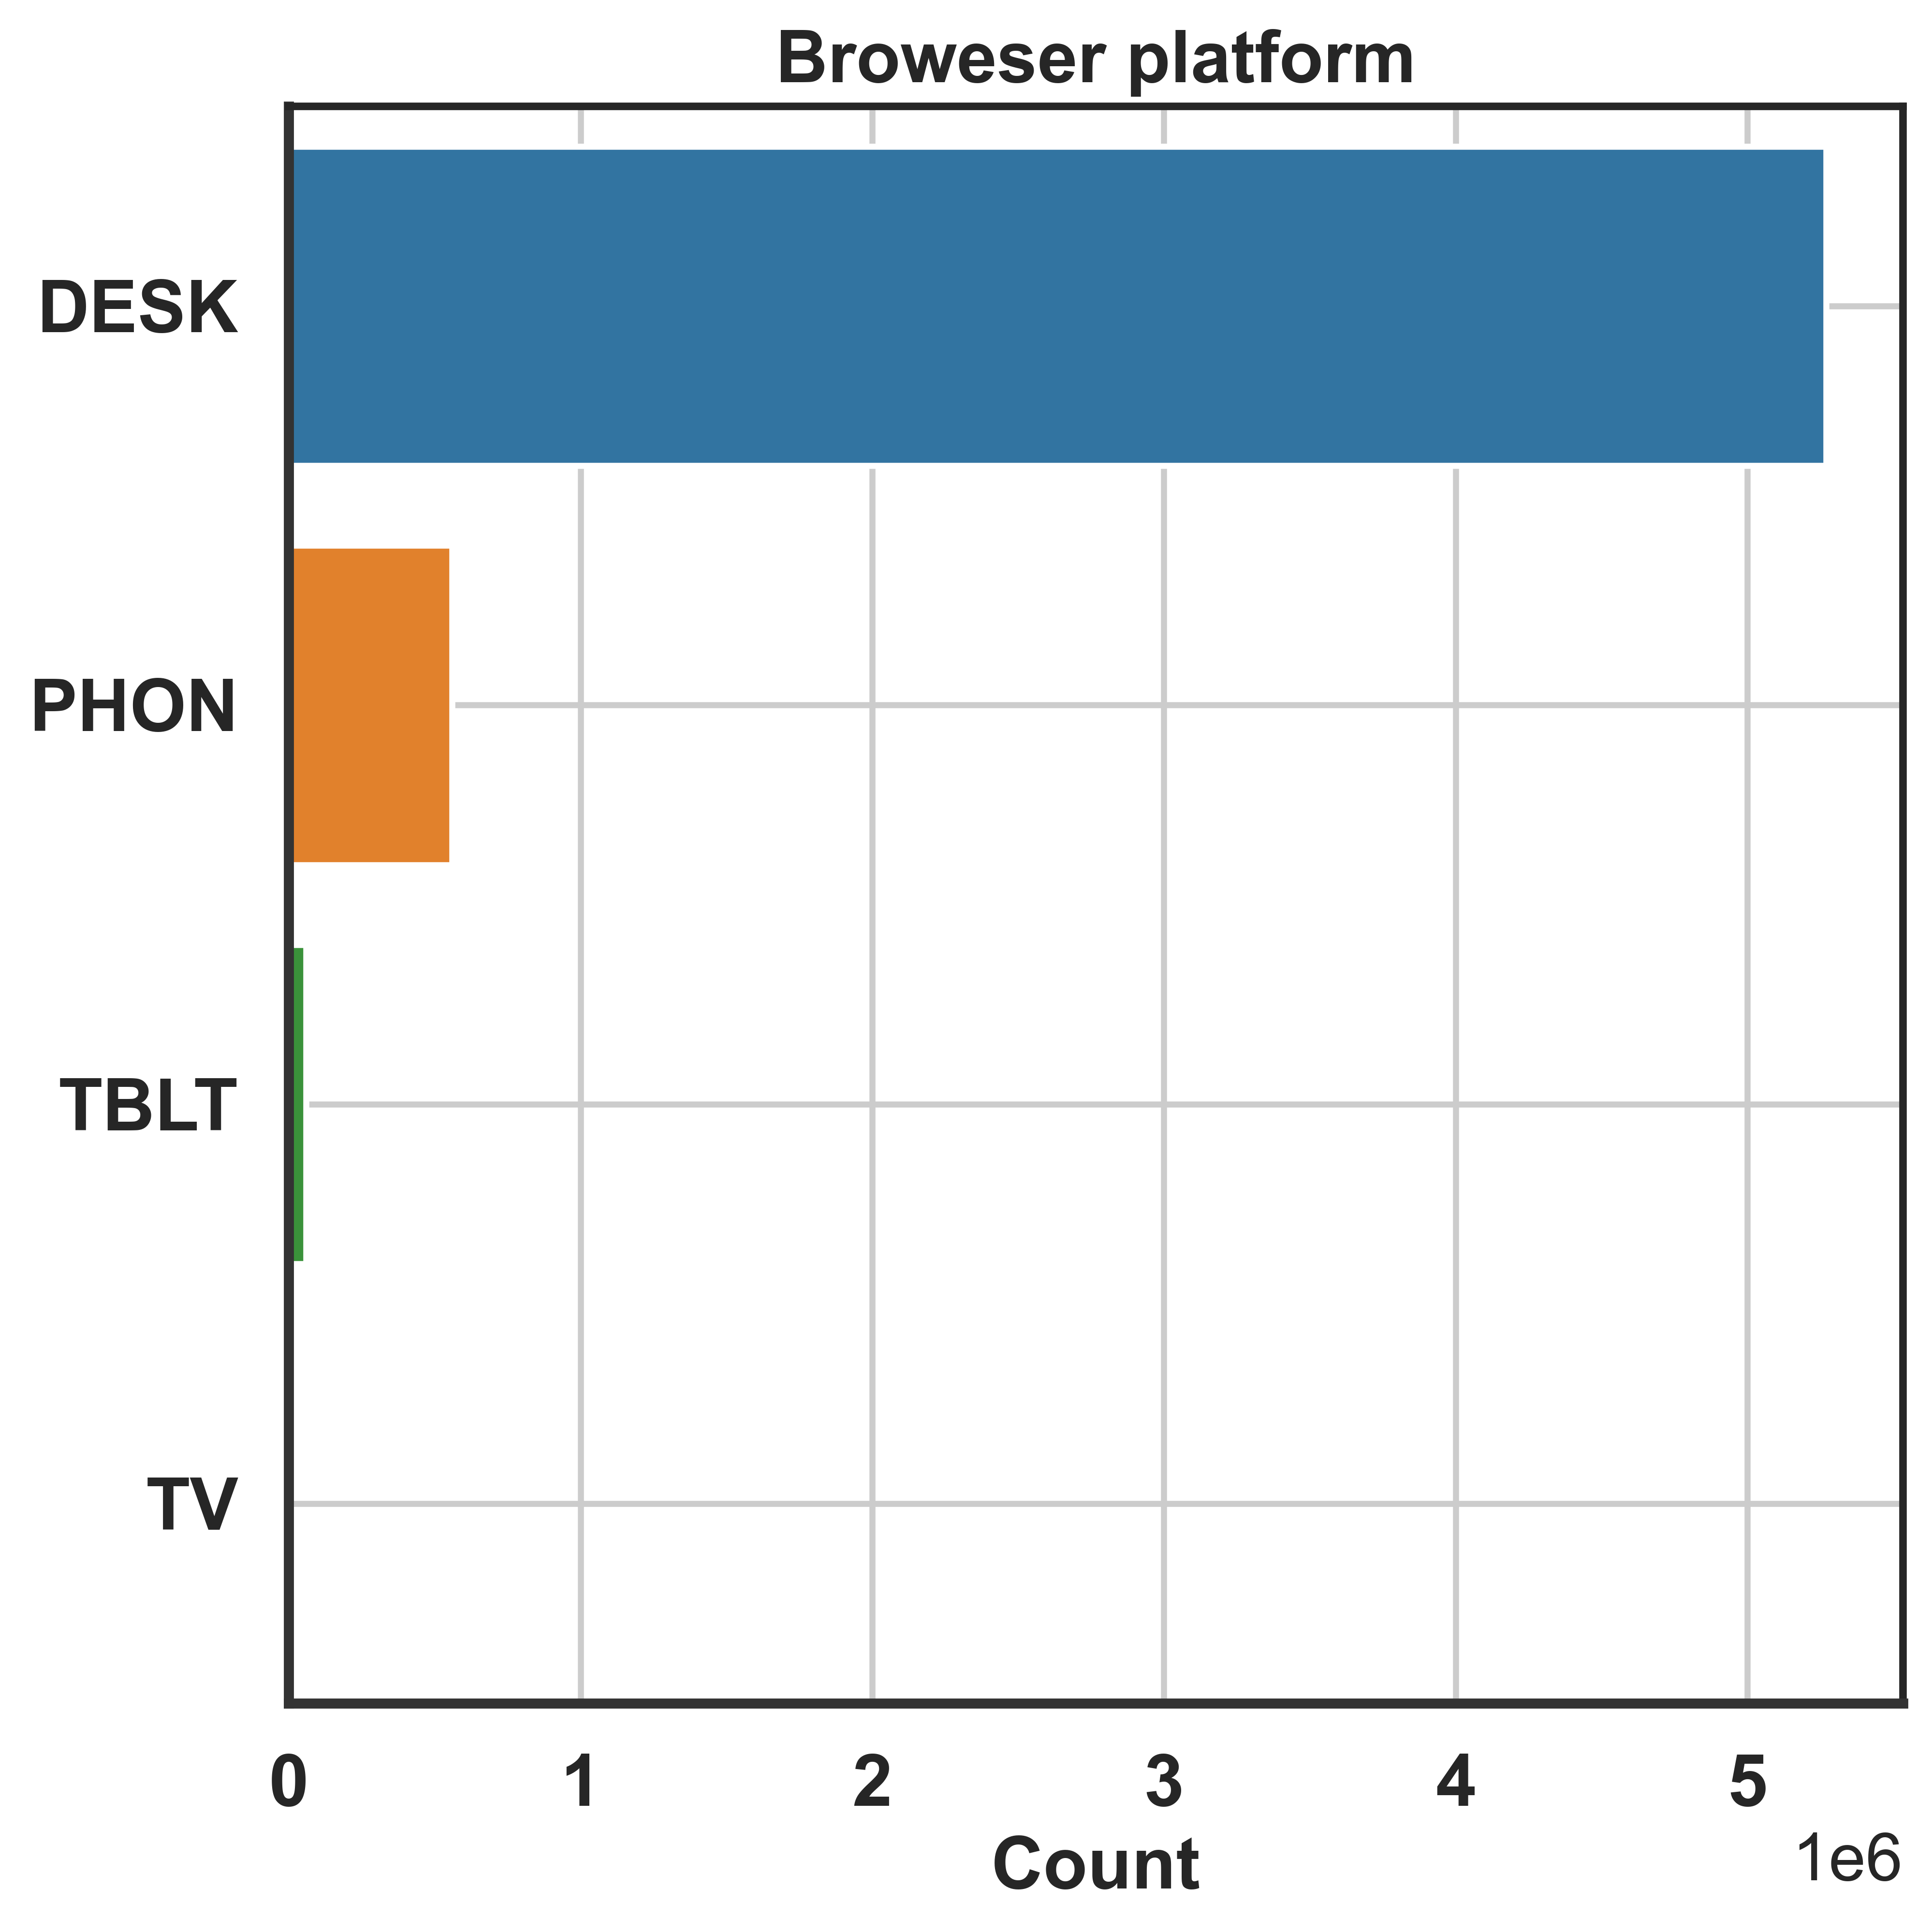

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
sns.countplot(data=last_three_days_recon, y='browser_platform')
ax.set_title('Broweser platform', fontdict={'weight': 'bold'})
# ax.set_ylabel('Target item taxonomy higher category', fontdict={'weight': 'bold'})
ax.set_ylabel('')
ax.set_xlabel('Count', fontdict={'weight': 'bold'})
ax.grid()
ax.tick_params(axis ='both', which ='major', labelsize = 18)
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
fig.tight_layout()
fig.savefig('./histogram-browser-platform.png')
plt.show()